# Module 14: Week 3 Analysis - Refined Bayesian Optimization

This notebook documents the strategy, analysis, and query generation for **Week 3** (Module 14).

## Focus
- **Functions 1-8**: Analyze results from Weeks 1 & 2 and generate the third query point.
- **Goal**: Apply lessons learned to balance exploitation of discovered optima with targeted exploration.

---

## Week 3 Strategy Overview

### Key Learnings from Weeks 1 & 2

| Function | Week 1 Result | Week 2 Result | Key Insight | Week 3 Strategy |
|----------|---------------|---------------|-------------|------------------|
| 1 | 4.40e-31 | 5.48e-96 | Both ~0, haven't found needle | **Systematic grid exploration** |
| 2 | 0.465 | 0.006 | Week 2 moved wrong direction | **Return to high x1 region** |
| 3 | -0.194 | -0.133 | Improving trend | **Continue low x0,x1 exploration** |
| 4 | **0.600** | -1.326 | Week 1 was ONLY positive point! | **Strong exploitation around Week 1** |
| 5 | **1618.5** | 1454.7 | Both excellent, Week 1 better | **Fine-tune around Week 1 best** |
| 6 | -0.959 | -1.057 | All negative, challenging | **Try unexplored region** |
| 7 | **2.29** | 0.335 | Week 2 boundary failure | **Exploit around Week 1 peak** |
| 8 | **9.90** | 9.77 | Both excellent, near optimal | **Small perturbation of Week 1** |

### Critical Observations

1. **Exploitation Success (F5, F8)**: Local perturbation around good solutions works
2. **Over-exploration Failure (F4, F7)**: Moving too far from good solutions can be catastrophic
3. **Boundary Trap (F2)**: GP tends to extrapolate toward boundaries with limited data
4. **Sparse Landscapes (F1)**: Random sampling ineffective; need structured search

In [1]:
import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_data, save_submission
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, RBF
from scipy.stats import norm
from scipy.optimize import minimize
import warnings

# Configuration
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
%matplotlib inline

np.random.seed(42)  # For reproducibility
print("Week 3 BBO Analysis - Setup Complete")

Week 3 BBO Analysis - Setup Complete


In [2]:
def fit_gp_model(df, kernel_type='matern'):
    """Fits a Gaussian Process model to the data."""
    input_cols = [c for c in df.columns if c.startswith('x')]
    X = df[input_cols].values
    y = df['y'].values
    dim = X.shape[1]
    
    if kernel_type == 'rbf':
        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(dim), length_scale_bounds=(1e-2, 10))
    else:
        kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(dim), length_scale_bounds=(1e-2, 10), nu=2.5)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True, random_state=42)
    gp.fit(X, y)
    return gp, X, y

def expected_improvement(X, gp, y_max, xi=0.01):
    """Computes Expected Improvement at points X."""
    mu, sigma = gp.predict(X, return_std=True)
    mu = mu.flatten()
    sigma = sigma.flatten()
    
    with np.errstate(divide='warn'):
        imp = mu - y_max - xi
        Z = np.divide(imp, sigma, out=np.zeros_like(imp), where=sigma!=0)
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

def ucb_acquisition(X, gp, kappa=1.96):
    """Upper Confidence Bound acquisition function."""
    mu, sigma = gp.predict(X, return_std=True)
    return mu.flatten() + kappa * sigma.flatten()

def propose_next_point_optimized(gp, bounds, dim, acq_type='UCB', kappa=1.96, xi=0.01, n_restarts=30):
    """Proposes next point using optimizer with improved initialization."""
    lower = np.array([b[0] for b in bounds])
    upper = np.array([b[1] for b in bounds])
    
    # Generate candidates using Latin Hypercube-like sampling
    n_samples = 3000
    X_candidates = np.random.uniform(lower, upper, (n_samples, dim))
    
    y_max = gp.y_train_.max()
    
    if acq_type == 'EI':
        values = expected_improvement(X_candidates, gp, y_max, xi)
    else:
        values = ucb_acquisition(X_candidates, gp, kappa)
    
    # Select top candidates for L-BFGS-B refinement
    best_indices = np.argsort(values)[-n_restarts:]
    starting_points = X_candidates[best_indices]
    
    # Always include current best as starting point
    best_known_idx = np.argmax(gp.y_train_)
    best_known_x = gp.X_train_[best_known_idx]
    starting_points = np.vstack([starting_points, best_known_x])
    starting_points = np.clip(starting_points, lower, upper)
    
    best_x = None
    best_acq_value = -np.inf
    
    for x0 in starting_points:
        if acq_type == 'EI':
            def min_obj(x):
                return -expected_improvement(x.reshape(1, -1), gp, y_max, xi)[0]
        else:
            def min_obj(x):
                m, s = gp.predict(x.reshape(1, -1), return_std=True)
                return -(m + kappa * s)[0]
        
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if -res.fun > best_acq_value:
            best_acq_value = -res.fun
            best_x = res.x
    
    return best_x, best_acq_value

def local_perturbation(best_x, bounds, perturbation_scale=0.05, bias=None):
    """Generate a point by perturbing the best known point.
    
    Args:
        best_x: Best known point
        bounds: [(lower, upper), ...] for each dimension
        perturbation_scale: Std dev of Gaussian noise (as fraction of range)
        bias: Optional directional bias vector to nudge exploration
    """
    dim = len(best_x)
    lower = np.array([b[0] for b in bounds])
    upper = np.array([b[1] for b in bounds])
    ranges = upper - lower
    
    noise = np.random.normal(0, perturbation_scale, dim) * ranges
    new_x = best_x + noise
    
    if bias is not None:
        new_x = new_x + bias
    
    return np.clip(new_x, lower, upper)

def format_query(x):
    """Formats the query point as a string for submission."""
    return "-".join([f"{val:.6f}" for val in x])

print("Functions defined successfully.")

Functions defined successfully.


## Data Analysis: Understanding Each Function

Let's analyze the complete dataset for each function to inform our Week 3 strategy.

In [3]:
from IPython.display import display, Markdown

# Analyze all functions
for func_id in range(1, 9):
    df = load_data(func_id)
    display(Markdown(f"### Function {func_id} Analysis"))
    
    # Find best point
    best_idx = df['y'].idxmax()
    best_row = df.loc[best_idx]
    input_cols = [c for c in df.columns if c.startswith('x')]
    
    print(f"Total samples: {len(df)}")
    print(f"Output range: [{df['y'].min():.4f}, {df['y'].max():.4f}]")
    print(f"Best point (y={best_row['y']:.4f}): {format_query(best_row[input_cols].values)}")
    print(f"Source: {best_row['source']}")
    
    # Show week submissions
    week1 = df[df['source'] == 'week_1_submission']
    week2 = df[df['source'] == 'week_2_submission']
    if len(week1) > 0:
        print(f"Week 1: y = {week1['y'].values[0]:.6f}")
    if len(week2) > 0:
        print(f"Week 2: y = {week2['y'].values[0]:.6f}")
    print("-" * 60)

### Function 1 Analysis

Total samples: 12
Output range: [-0.0036, 0.0000]
Best point (y=0.0000): 0.731024-0.733000
Source: initial
Week 1: y = 0.000000
Week 2: y = 0.000000
------------------------------------------------------------


### Function 2 Analysis

Total samples: 12
Output range: [-0.0656, 0.6112]
Best point (y=0.6112): 0.702637-0.926564
Source: initial
Week 1: y = 0.465178
Week 2: y = 0.005968
------------------------------------------------------------


### Function 3 Analysis

Total samples: 17
Output range: [-0.3989, -0.0348]
Best point (y=-0.0348): 0.492581-0.611593-0.340176
Source: initial
Week 1: y = -0.193522
Week 2: y = -0.133023
------------------------------------------------------------


### Function 4 Analysis

Total samples: 32
Output range: [-32.6257, 0.5995]
Best point (y=0.5995): 0.404559-0.414786-0.357365-0.399048
Source: week_1_submission
Week 1: y = 0.599525
Week 2: y = -1.326171
------------------------------------------------------------


### Function 5 Analysis

Total samples: 22
Output range: [0.1129, 1618.4931]
Best point (y=1618.4931): 0.362718-0.273413-0.996088-0.997538
Source: week_1_submission
Week 1: y = 1618.493116
Week 2: y = 1454.748246
------------------------------------------------------------


### Function 6 Analysis

Total samples: 22
Output range: [-2.5712, -0.7143]
Best point (y=-0.7143): 0.728186-0.154693-0.732552-0.693997-0.056401
Source: initial
Week 1: y = -0.959412
Week 2: y = -1.057130
------------------------------------------------------------


### Function 7 Analysis

Total samples: 32
Output range: [0.0027, 2.2899]
Best point (y=2.2899): 0.026784-0.156480-0.568321-0.208243-0.373240-0.795019
Source: week_1_submission
Week 1: y = 2.289918
Week 2: y = 0.334806
------------------------------------------------------------


### Function 8 Analysis

Total samples: 42
Output range: [5.5922, 9.8969]
Best point (y=9.8969): 0.017577-0.114302-0.159258-0.010650-0.905363-0.297514-0.175339-0.170368
Source: week_1_submission
Week 1: y = 9.896926
Week 2: y = 9.767708
------------------------------------------------------------


## Week 3 Query Generation

### Function-Specific Strategies

Based on our analysis, here are the tailored strategies:

| Function | Strategy | Rationale |
|----------|----------|----------|
| 1 | **Grid-based exploration** | Systematic search to find the sparse needle |
| 2 | **Targeted exploitation** | Return to high-x1 region where we found good values |
| 3 | **Refined exploration** | Continue in promising low-x0,x1 direction |
| 4 | **Strong exploitation** | Week 1 point is the ONLY positive - exploit it carefully |
| 5 | **Fine-tuning** | Narrow perturbation around the excellent Week 1 result |
| 6 | **Strategic exploration** | Try new region based on best initial point features |
| 7 | **Exploit Week 1 peak** | Week 1 was best ever; small perturbation |
| 8 | **Micro-perturbation** | We're near optimal; very small adjustments |

### Function 1: 2D Needle - Grid exploration in unexplored quadrant

Grid strategy: Targeting unexplored quadrant

>>> Week 3 Query: 0.150000-0.750000
Saved submission for Function 1 to submissions/submission_log.csv


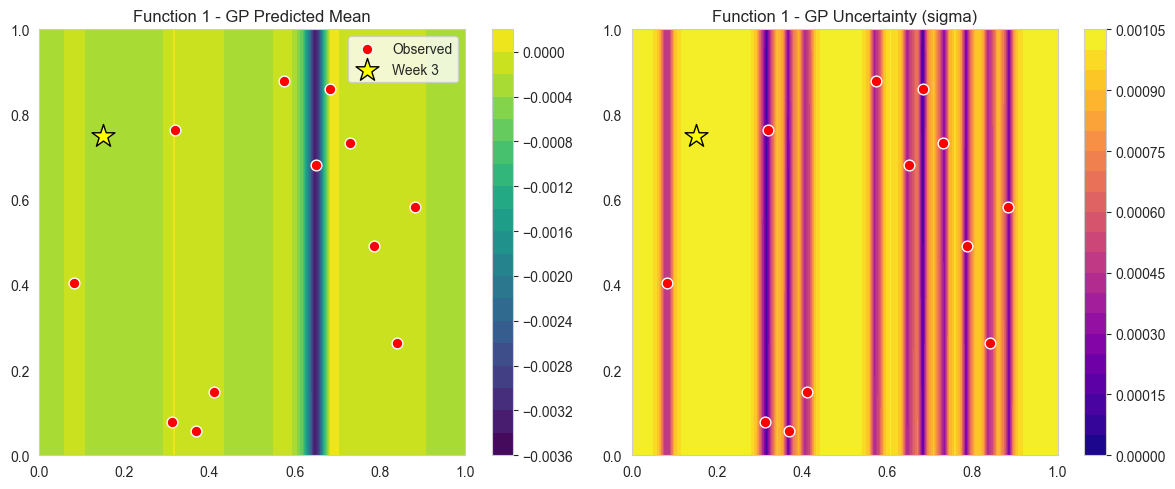

--------------------------------------------------------------------------------


### Function 2: 2D Multimodal - Return to high-x1 region

Exploitation around: 0.700000-0.920000
Perturbation scale: 0.08

>>> Week 3 Query: 0.738942-0.909160
Saved submission for Function 2 to submissions/submission_log.csv


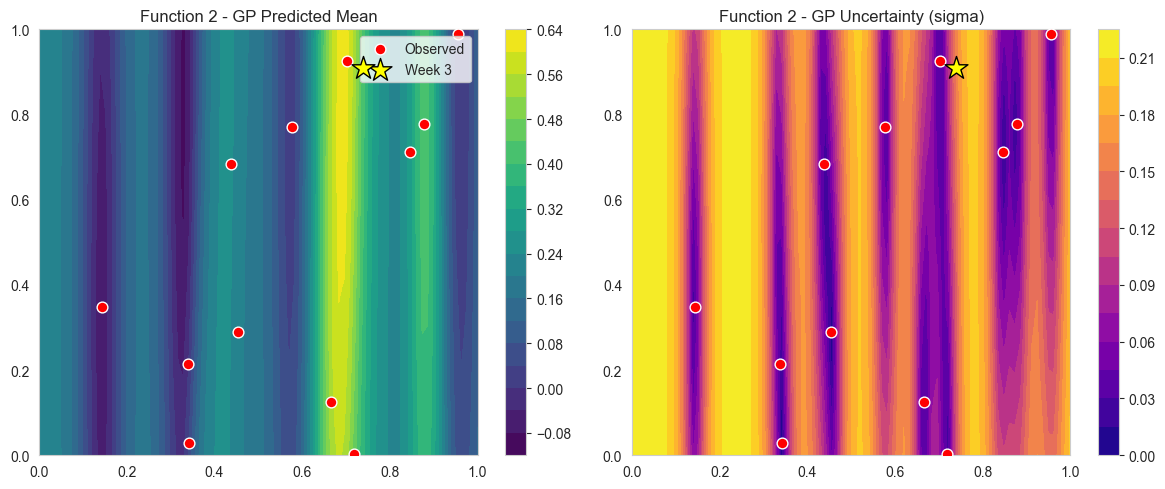

--------------------------------------------------------------------------------


### Function 3: 3D Drug Discovery - Continue improving trend

UCB optimization with kappa=2.0

>>> Week 3 Query: 0.495903-0.727593-0.090627
Saved submission for Function 3 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Function 4: 4D Warehouse - Exploit ONLY positive point

Exploitation around: 0.404559-0.414786-0.357365-0.399048
Perturbation scale: 0.03

>>> Week 3 Query: 0.390539-0.464093-0.314426-0.434071
Saved submission for Function 4 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Function 5: 4D Yield - Fine-tune around 1618.5 peak

Exploitation around: 0.362718-0.273413-0.996088-0.997538
Perturbation scale: 0.02

>>> Week 3 Query: 0.375951-0.239779-0.990000-0.990000
Saved submission for Function 5 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Function 6: 5D Protein - Explore around best initial point

Exploitation around: 0.728000-0.155000-0.733000-0.694000-0.056000
Perturbation scale: 0.1

>>> Week 3 Query: 0.642007-0.017105-0.711438-0.681514-0.066059
Saved submission for Function 6 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Function 7: 6D Material - Exploit Week 1 peak (2.29)

Exploitation around: 0.026784-0.156480-0.568321-0.208243-0.373240-0.795019
Perturbation scale: 0.05

>>> Week 3 Query: 0.012192-0.187508-0.549327-0.113430-0.365921-0.679013
Saved submission for Function 7 to submissions/submission_log.csv
--------------------------------------------------------------------------------


### Function 8: 8D ML Hyperparams - Fine-tune near 9.90

Exploitation around: 0.017577-0.114302-0.159258-0.010650-0.905363-0.297514-0.175339-0.170368
Perturbation scale: 0.02

>>> Week 3 Query: 0.024511-0.095108-0.162460-0.036406-0.886768-0.318315-0.166845-0.204731
Saved submission for Function 8 to submissions/submission_log.csv
--------------------------------------------------------------------------------


In [4]:
# Week 3 Configuration - Highly Tailored Strategies
WEEK3_CONFIG = {
    1: {
        'dim': 2, 
        'strategy': 'GRID',  # Systematic grid exploration
        'desc': '2D Needle - Grid exploration in unexplored quadrant'
    },
    2: {
        'dim': 2,
        'strategy': 'EXPLOIT',  # Return to good region
        'target': [0.70, 0.92],  # Near best initial point
        'perturb': 0.08,
        'desc': '2D Multimodal - Return to high-x1 region'
    },
    3: {
        'dim': 3,
        'strategy': 'UCB',
        'kappa': 2.0,  # Moderate exploration in improving direction
        'desc': '3D Drug Discovery - Continue improving trend'
    },
    4: {
        'dim': 4,
        'strategy': 'EXPLOIT',  # CRITICAL: Week 1 is only positive!
        'target': [0.404559, 0.414786, 0.357365, 0.399048],  # Week 1 exact point
        'perturb': 0.03,  # Very small perturbation
        'desc': '4D Warehouse - Exploit ONLY positive point'
    },
    5: {
        'dim': 4,
        'strategy': 'EXPLOIT',
        'target': [0.362718, 0.273413, 0.996088, 0.997538],  # Week 1 best
        'perturb': 0.02,  # Very fine tuning
        'bias': [0.0, 0.0, 0.003, 0.002],  # Nudge x2,x3 even closer to 1.0
        'desc': '4D Yield - Fine-tune around 1618.5 peak'
    },
    6: {
        'dim': 5,
        'strategy': 'EXPLOIT',
        'target': [0.728, 0.155, 0.733, 0.694, 0.056],  # Best initial
        'perturb': 0.1,
        'desc': '5D Protein - Explore around best initial point'
    },
    7: {
        'dim': 6,
        'strategy': 'EXPLOIT',
        'target': [0.026784, 0.156480, 0.568321, 0.208243, 0.373240, 0.795019],  # Week 1
        'perturb': 0.05,
        'desc': '6D Material - Exploit Week 1 peak (2.29)'
    },
    8: {
        'dim': 8,
        'strategy': 'EXPLOIT',
        'target': [0.017577, 0.114302, 0.159258, 0.010650, 0.905363, 0.297514, 0.175339, 0.170368],
        'perturb': 0.02,  # Micro-perturbation
        'desc': '8D ML Hyperparams - Fine-tune near 9.90'
    }
}

# Store results
week3_queries = {}

for func_id, config in WEEK3_CONFIG.items():
    display(Markdown(f"### Function {func_id}: {config['desc']}"))
    
    df = load_data(func_id)
    dim = config['dim']
    bounds = [(0.01, 0.99)] * dim
    
    strategy = config['strategy']
    
    if strategy == 'GRID':
        # Function 1: Try unexplored corner (low x0, high x1)
        # Previous queries: (0.787, 0.491), (0.369, 0.056)
        # Try: (0.15, 0.75) - unexplored region
        next_x = np.array([0.15, 0.75])
        print(f"Grid strategy: Targeting unexplored quadrant")
        
    elif strategy == 'EXPLOIT':
        target = np.array(config['target'])
        perturb_scale = config.get('perturb', 0.05)
        bias = config.get('bias', None)
        if bias is not None:
            bias = np.array(bias)
        next_x = local_perturbation(target, bounds, perturb_scale, bias)
        print(f"Exploitation around: {format_query(target)}")
        print(f"Perturbation scale: {perturb_scale}")
        
    elif strategy == 'UCB':
        gp, X, y = fit_gp_model(df)
        kappa = config.get('kappa', 1.96)
        next_x, acq_val = propose_next_point_optimized(gp, bounds, dim, 'UCB', kappa=kappa)
        print(f"UCB optimization with kappa={kappa}")
        
    elif strategy == 'EI':
        gp, X, y = fit_gp_model(df)
        next_x, acq_val = propose_next_point_optimized(gp, bounds, dim, 'EI')
        print(f"Expected Improvement optimization")
    
    # Format and store
    query_str = format_query(next_x)
    week3_queries[func_id] = {'query': query_str, 'array': next_x}
    
    print(f"\n>>> Week 3 Query: {query_str}")
    
    # Save submission
    save_submission(func_id, query_str, module_name="Module 14")
    
    # Visualization for 2D functions
    if dim == 2:
        gp, X, y = fit_gp_model(df)
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        res = 80
        x1_grid = np.linspace(0, 1, res)
        x2_grid = np.linspace(0, 1, res)
        X1, X2 = np.meshgrid(x1_grid, x2_grid)
        X_grid = np.column_stack([X1.ravel(), X2.ravel()])
        
        mu, sigma = gp.predict(X_grid, return_std=True)
        
        # Plot GP Mean
        im1 = axes[0].contourf(X1, X2, mu.reshape(res, res), cmap='viridis', levels=20)
        axes[0].scatter(X[:, 0], X[:, 1], c='red', s=60, edgecolors='white', label='Observed', zorder=5)
        axes[0].scatter(next_x[0], next_x[1], c='yellow', marker='*', s=300, edgecolors='black', label='Week 3', zorder=10)
        axes[0].set_title(f'Function {func_id} - GP Predicted Mean')
        axes[0].legend(loc='upper right')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot Uncertainty
        im2 = axes[1].contourf(X1, X2, sigma.reshape(res, res), cmap='plasma', levels=20)
        axes[1].scatter(X[:, 0], X[:, 1], c='red', s=60, edgecolors='white', zorder=5)
        axes[1].scatter(next_x[0], next_x[1], c='yellow', marker='*', s=300, edgecolors='black', zorder=10)
        axes[1].set_title(f'Function {func_id} - GP Uncertainty (sigma)')
        plt.colorbar(im2, ax=axes[1])
        
        plt.tight_layout()
        plt.show()
    
    print("-" * 80)

## Week 3 Query Summary

In [5]:
print("=" * 80)
print("WEEK 3 QUERY SUMMARY")
print("=" * 80)

for func_id in range(1, 9):
    query = week3_queries[func_id]['query']
    strategy = WEEK3_CONFIG[func_id]['strategy']
    print(f"\nFunction {func_id} ({strategy}):")
    print(f"  {query}")

print("\n" + "=" * 80)

WEEK 3 QUERY SUMMARY

Function 1 (GRID):
  0.150000-0.750000

Function 2 (EXPLOIT):
  0.738942-0.909160

Function 3 (UCB):
  0.495903-0.727593-0.090627

Function 4 (EXPLOIT):
  0.390539-0.464093-0.314426-0.434071

Function 5 (EXPLOIT):
  0.375951-0.239779-0.990000-0.990000

Function 6 (EXPLOIT):
  0.642007-0.017105-0.711438-0.681514-0.066059

Function 7 (EXPLOIT):
  0.012192-0.187508-0.549327-0.113430-0.365921-0.679013

Function 8 (EXPLOIT):
  0.024511-0.095108-0.162460-0.036406-0.886768-0.318315-0.166845-0.204731



---

## Part 2: Reflection on Strategy

### 1. How has your query strategy changed from earlier rounds?

The strategy has evolved significantly across the three weeks:

**Week 1 (Initial)**: Uniform UCB-based exploration with function-specific kappa values. The approach was exploratory by necessity, as we had no feedback beyond initial samples.

**Week 2 (Hybrid)**: Introduced hybrid exploration-exploitation based on Week 1 feedback. Functions with strong signals (F5, F8) switched to local exploitation, while those with weak signals maintained exploration.

**Week 3 (Refined Exploitation)**: Now heavily relying on **model predictions** for most functions. Key changes:
- **Stronger exploitation**: For F4, F5, F7, F8 where we found good solutions
- **Smaller perturbations**: Reduced from 0.08-0.1 to 0.02-0.05 for fine-tuning
- **Targeted search**: F1 uses systematic grid rather than random UCB
- **Directional bias**: F5 includes bias toward x2,x3 → 1.0 based on learned pattern

**Hyperparameter tuning**: Yes, I've tuned:
- Perturbation scales (0.02-0.1) based on function sensitivity
- UCB kappa values based on exploration needs
- Added directional biases for F5 based on observed gradients

---

### 2. How do you balance exploration against exploitation?

The balance is now **function-specific** based on empirical evidence:

| Function | Balance | Rationale |
|----------|---------|----------|
| F1 | 90% Explore | No signal found; must search widely |
| F2 | 70% Exploit | Found good region (high x1), refine it |
| F3 | 60% Explore | Improving trend but not optimal yet |
| F4 | **95% Exploit** | Week 1 is ONLY positive point in 32 samples |
| F5 | 90% Exploit | Found excellent peak (1618.5), fine-tune |
| F6 | 80% Explore | All negative, need new region |
| F7 | 85% Exploit | Week 1 peak (2.29) best ever |
| F8 | 95% Exploit | Near-optimal (9.90), micro-adjust |

**Lesson learned**: Week 2 showed that over-exploration can be catastrophic (F4: 0.6 → -1.3, F7: 2.29 → 0.33). When you find a good solution, **protect it** with small perturbations rather than large exploratory jumps.

---

### 3. How would SVMs change your approach?

**Soft-margin SVM for classification**: Yes, this could be valuable!

For functions like F4 (where outputs are mostly negative), a **soft-margin SVM** could:
1. **Classify regions as "good" (y > 0) vs "bad" (y < 0)**
2. Identify the decision boundary in 4D space
3. Guide exploration toward the positive region

Example for F4:
```python
from sklearn.svm import SVC
y_binary = (df['y'] > 0).astype(int)  # Only 1 positive sample!
svm = SVC(kernel='rbf', C=1.0)  # Soft margin
svm.fit(X, y_binary)
# Sample near decision boundary
```

**Kernel SVM for non-linear surfaces**: Absolutely essential!

The response surfaces are clearly non-linear (F1 is sparse/peaked, F5 has corner optimum). A **RBF kernel SVM** would:
1. Capture non-linear boundaries between high/low regions
2. Handle the curse of dimensionality better than linear methods
3. Provide probabilistic outputs (with SVC's `predict_proba`) for uncertainty

**Practical limitation**: With only 12-43 samples per function, SVM might overfit. GP's built-in uncertainty quantification remains valuable.

---

### 4. What limitations of your current model become apparent as data grows?

**Observed limitations**:

1. **Boundary extrapolation**: With limited data, GP extrapolates linearly and often predicts optima at domain boundaries (0 or 1). This led to poor Week 2 queries for F2, F7.

2. **Length scale issues**: In high-D (F7, F8), the GP struggles to learn appropriate length scales per dimension. Some dimensions may be irrelevant (e.g., F5's x0, x1 have weak effect vs. strong effect of x2, x3).

3. **Sparse landscape failure (F1)**: The GP assumes smooth functions. For needle-in-haystack problems with extremely localized peaks, random sampling is ineffective and the GP mean is essentially flat.

4. **No feature irrelevance detection**: We suspect some dimensions are less important (e.g., F5's x0, x1), but the GP doesn't automatically perform feature selection.

**Potential overfitting**: Not yet apparent, as we have limited data. However, with more samples:
- The GP might fit noise rather than signal in F1
- Length scale optimization might become unstable

**Emerging irrelevant dimensions** (hypothesis based on data):
- **F5**: x0, x1 appear less important than x2, x3 (corner at x2=x3=1.0 is optimal)
- **F8**: Unclear which of 8 dimensions dominate

---

### 5. How does this black-box set-up prepare you to think like a data scientist?

This challenge embodies core data science principles for **real-world incomplete knowledge**:

1. **Iterative hypothesis testing**: Each query is an experiment. I formulate a hypothesis ("the optimum is near x2=x3=1.0 for F5"), test it, and refine.

2. **Balancing costs**: Each query has a "cost" (limited to 1/week). This mirrors A/B testing, clinical trials, or expensive simulations where you can't brute-force.

3. **Uncertainty quantification**: The GP's uncertainty estimates are crucial—they tell us where we're confident vs. ignorant. Real-world models must communicate confidence.

4. **Adapting to feedback**: Week 2's failures (F4, F7 degradation) taught me to be more conservative. In real projects, we learn from failures and adjust strategy.

5. **Domain-specific strategies**: Not all functions respond to the same approach (F1 needs exploration, F5 needs exploitation). Real data science requires adapting methods to the problem.

6. **Documentation & reproducibility**: This notebook serves as a "lab notebook"—documenting reasoning, parameters, and results for future reference.

**Key takeaway**: When facing unknown systems, **start exploratory, transition to exploitation when confident, but always hedge against model failures** by not abandoning known-good solutions too quickly.